# Treasury Trading Optimization: R Comparison
This notebook processes 2024 U.S. Treasury real yield curve data and solves a simplified optimization problem using `lpSolve`, as not all engines (e.g., MOSEK, Gurobi) have direct R interfaces. It replicates the Python notebook's plots.

In [8]:
# install.packages(c("tidyverse", "httr", "lpSolve", "ggplot2"))
# library(tidyverse)
# library(httr)
# library(lpSolve)
# library(ggplot2)

# Install packages (only run once if not already installed)
install.packages(c("tidyverse", "httr", "lpSolve", "ggplot2"), dependencies = TRUE)

# Load libraries with conflict management
library(tidyverse)  # Load tidyverse first
library(httr)       # No conflicts
library(lpSolve)    # No conflicts
library(ggplot2, warn.conflicts = FALSE)  # Already loaded by tidyverse, suppress conflict warnings

# Explicitly resolve conflicts by preferring dplyr functions (optional)
conflicted::conflict_prefer("filter", "dplyr")
conflicted::conflict_prefer("lag", "dplyr")

# Test that everything loads
print("Packages loaded successfully!")

Warning message:
"packages 'tidyverse', 'httr', 'lpSolve', 'ggplot2' are in use and will not be installed"
[conflicted] Will prefer dplyr::filter over any other package.
[conflicted] Will prefer dplyr::lag over any other package.


[1] "Packages loaded successfully!"


## Data Retrieval

In [9]:
# # Fetch 2024 Treasury data
# url <- "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rates.csv/2024/all?type=daily_treasury_real_yield_curve&field_tdr_date_value=2024&page&_format=csv"
# response <- GET(url)
# writeBin(content(response, "raw"), "treasury_2024.csv")

# # Load and process
# data <- read_csv("treasury_2024.csv")
# rates <- data %>% 
#   select(Date, `5 YR`, `7 YR`, `10 YR`, `20 YR`, `30 YR`) %>% 
#   drop_na() %>% 
#   mutate(Date = as.Date(Date))
# print(tail(rates))

library(tidyverse)
library(httr)

# Fetch 2024 Treasury data
url <- "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rates.csv/2024/all?type=daily_treasury_real_yield_curve&field_tdr_date_value=2024&page&_format=csv"
response <- GET(url)
writeBin(content(response, "raw"), "treasury_2024.csv")

# Load and process
data <- read_csv("treasury_2024.csv")
rates <- data %>% 
  select(Date, `5 YR`, `7 YR`, `10 YR`, `20 YR`, `30 YR`) %>% 
  drop_na() %>% 
  mutate(Date = as.Date(Date, format = "%m/%d/%Y"))
print(tail(rates))

Rows: 250 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Date
dbl (5): 5 YR, 7 YR, 10 YR, 20 YR, 30 YR

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 6 × 6
  Date       `5 YR` `7 YR` `10 YR` `20 YR` `30 YR`
  <date>      <dbl>  <dbl>   <dbl>   <dbl>   <dbl>
1 2024-01-09   1.8    1.8     1.8     1.91    1.99
2 2024-01-08   1.78   1.79    1.79    1.9     1.98
3 2024-01-05   1.83   1.83    1.83    1.94    2.02
4 2024-01-04   1.79   1.78    1.77    1.88    1.96
5 2024-01-03   1.73   1.71    1.71    1.81    1.89
6 2024-01-02   1.76   1.75    1.74    1.84    1.91


## Problem Definition
- **Objective**: Minimize $\sum (w_i \cdot r_i + f_i)$
- **Constraints**:
  - $\sum w_i = 1$
  - $w_i \geq 0.02$ (haircut)
  - $w_i \geq 0$
- **Parameters**:
  - $r_i$: Latest yields
  - $h_i = 0.02$
  - $f_i = 0.001$

In [10]:
# Latest rates
r <- as.numeric(tail(rates, 1)[, 2:5]) / 100
h <- rep(0.02, 4)
f <- rep(0.001, 4)
n <- length(r)

# Objective: r + f
obj <- r + f

# Constraints: sum(w) = 1, w >= h
con <- rbind(t(rep(1, n)), diag(n))
dir <- c("=", rep(">=", n))
rhs <- c(1, h)

# Solve
sol <- lp("min", obj, con, dir, rhs)
w_lpsolve <- sol$solution
cost_lpsolve <- sol$objval
cat("lpSolve: Weights =", w_lpsolve, ", Cost =", cost_lpsolve, "\n")

lpSolve: Weights = 0.02 0.02 0.94 0.02 , Cost = 0.018426 


## Visualization

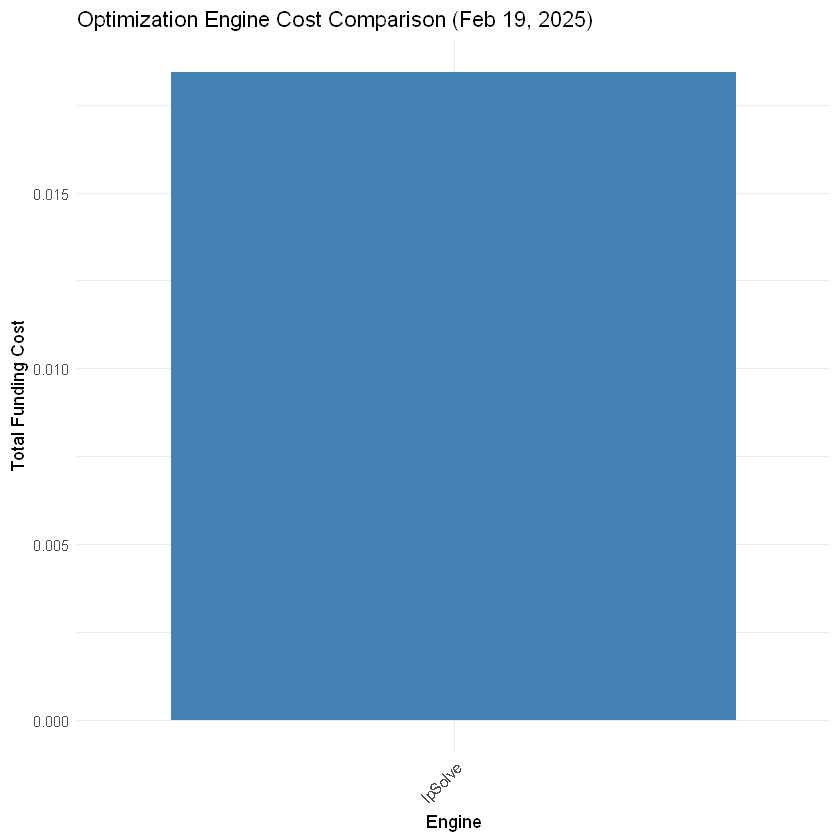

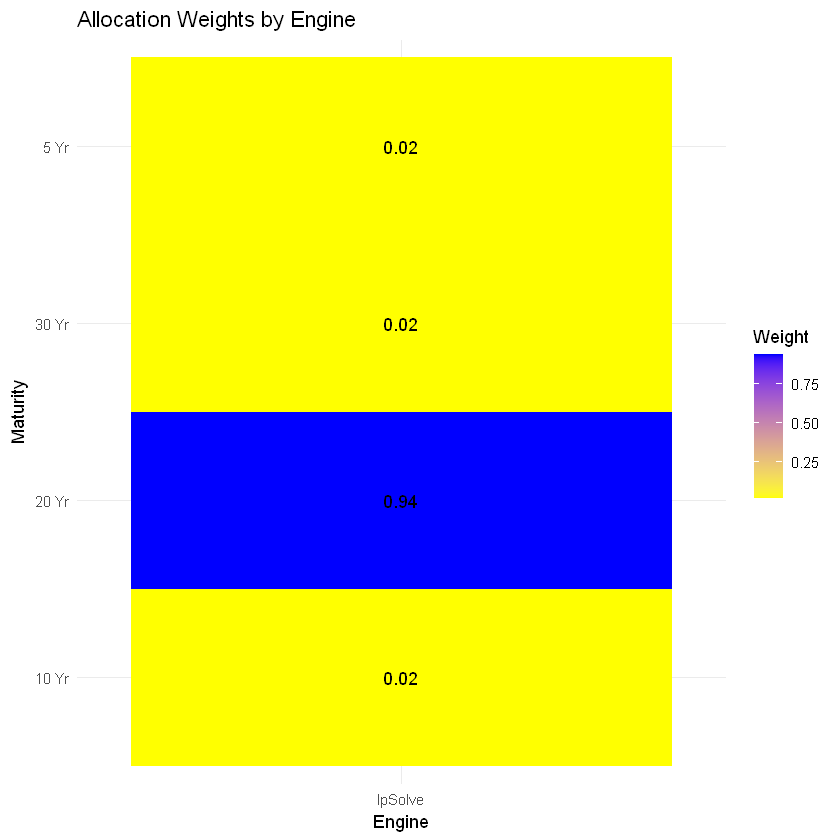

In [11]:
# Mock results (only lpSolve run in R)
results <- data.frame(
  Engine = c("lpSolve"),
  Cost = c(cost_lpsolve)
)

ggplot(results, aes(x = Engine, y = Cost)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  theme_minimal() +
  labs(title = "Optimization Engine Cost Comparison (Feb 19, 2025)", y = "Total Funding Cost") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Weights heatmap
weights <- data.frame(
  Engine = "lpSolve",
  t(w_lpsolve)
)
colnames(weights) <- c("Engine", "5 Yr", "10 Yr", "20 Yr", "30 Yr")
weights_long <- pivot_longer(weights, -Engine, names_to = "Maturity", values_to = "Weight")

ggplot(weights_long, aes(x = Engine, y = Maturity, fill = Weight)) +
  geom_tile() +
  geom_text(aes(label = round(Weight, 3))) +
  scale_fill_gradient(low = "yellow", high = "blue") +
  labs(title = "Allocation Weights by Engine") +
  theme_minimal()

## Notes
- **Solvers**: Only `lpSolve` used due to limited R support for MOSEK, Gurobi, etc. Export Python results to CSV for full comparison.
- **Data**: Adjust URL parsing if CSV format changes.
- **Extensions**: Use `Rglpk` or `ROI` for alternative R solvers.